In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Data Field Definitions
- step: is a timestep, each timestep is 0.25 seconds
- spool: is the integral of material feedrate from the beginning of the production. This is proportional to the mass of the total fiber extruded.
- diameter: is in 10e-5 meter
- speed: is mapped between 0 and 100
- motorV: is the PWM dutycycle of the motor and it's mapped between 0 and 100
- extfrq: is the frequency of the feeding extruder, which corresponds to the feedrate of the material
- temp: is the temperture of the heating chamber
- rests of the columns can be ignored for now

- Explore = Train Data; Exploit = Test Data

### Only uncomment and re-run the below code to change the base processed data

In [2]:
# filenames = {
#     'explore0':'2019_08_20_14_38.txt',
#     'explore1':'2019_09_09_09_54.txt',
#     'exploit0':'2019_08_20_15_36.txt',
#     'exploit1':'2019_08_20_16_31.txt',
#     'exploit2':'2019_08_20_17_06.txt', 
#     'exploit3':'2019_08_21_13_04.txt',
#     'exploit4':'2019_08_21_13_44.txt',
#     'exploit5':'2019_08_21_16_19.txt'
# }
# columns = ['step', 'spool', 'diameter', 'speed', 'motorV', 'extfrq', 'target', 'greedy_m', 'greedy_e', 
#            'reward', 'Q_exam', 'am_exam', 'a_exam', 'unk', 'temp']

# # Create dict of dataframes
# data = {}
# for key in filenames:
#     df = pd.read_csv('data/'+filenames[key], header=0, names=columns)
#     df.reset_index(inplace=True, drop=True)
#     df = df.drop(['unk', 'Q_exam', 'am_exam', 'a_exam', 'greedy_m', 'greedy_e', 'reward', 'step'], axis=1)
#     for col in df.columns:
#         df[col] = df[col].str.split(':').apply(lambda x: x[1])
#     df = df.apply(pd.to_numeric)
#     # Split dfs where 'spool' resets to zero
#     last_split = 0
#     split_idx = df[df.spool == 0].index.tolist()
#     split_idx.append(-1)
#     for n,i in enumerate(split_idx):
#         df_run = df[last_split:i]
#         if len(df_run) > 0:
#             data[key+'_'+str(n)] = df_run.reset_index(drop=True)
#         last_split = i
        
# data_keys = list(data.keys())
# print('# of keys in data: ', len(data_keys))
# print(data_keys)

In [3]:
# with open('data_processed/data_dict.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## How to import processed data into a new file/notebook:
Run the code in the cell below:

In [4]:
with open('data_processed/data_dict.pickle', 'rb') as handle:
    data = pickle.load(handle)
data_keys = list(data.keys())

And access a given dataframe, representing a single run (starting always with spool == 0) as follows:

In [5]:
df = data[data_keys[9]]
df.head()

,spool,diameter,speed,motorV,extfrq,target,temp
0,0.00,35.6,80.16,23.76,18.73,44.9,79.968
1,0.01,36.9,80.16,24.73,19.34,44.9,80.105
2,0.03,36.2,76.72,26.70,20.66,44.9,80.036
3,0.05,34.4,65.44,29.82,22.92,44.9,80.036
4,0.06,35.3,56.16,34.00,26.21,44.9,80.174


Length of each dataset in the data dictionary:

In [6]:
total = 0
for x in data_keys:
    print(x, len(data[x]))
    total += len(data[x])
print('total samples: ', total)

explore0_1 2693
explore0_2 2424
explore0_3 2530
explore0_4 2880
explore1_1 8890
explore1_2 8919
explore1_3 7789
explore1_4 7919
explore1_5 8143
exploit0_1 2530
exploit1_1 2826
exploit2_1 2735
exploit3_1 2484
exploit4_1 2597
exploit5_1 2582
total samples:  67941


### Train - Test Split
Shoot for 80-20% split:

In [7]:
train_keys = ['explore0_1','explore0_3','explore0_4','explore1_1','explore1_2','explore1_4','explore1_5',
             'exploit0_1','exploit2_1','exploit4_1','exploit5_1']

test_keys = ['explore0_2','explore1_3','exploit1_1','exploit3_1']

train_all = pd.concat([data[k] for k in train_keys])
test_all = pd.concat([data[k] for k in test_keys])

In [8]:
train_all

,spool,diameter,speed,motorV,extfrq,target,temp
0,0.00,30.2,74.56,21.16,16.38,41.9,79.555
1,0.01,31.4,74.32,22.66,16.87,41.9,79.521
2,0.03,30.0,70.32,24.88,18.31,41.9,79.555
3,0.04,33.7,55.60,28.57,20.51,41.9,79.624
4,0.06,33.0,44.24,33.48,23.51,41.9,79.521
...,...,...,...,...,...,...,...
2577,99.79,45.5,88.80,87.30,80.55,45.0,80.002
2578,99.82,44.6,88.56,87.37,80.39,45.0,80.002
2579,99.86,42.7,88.80,87.36,80.27,45.0,80.002
2580,99.90,45.2,88.96,87.32,80.16,45.0,80.002


## Basic Analysis of Processed Raw Data

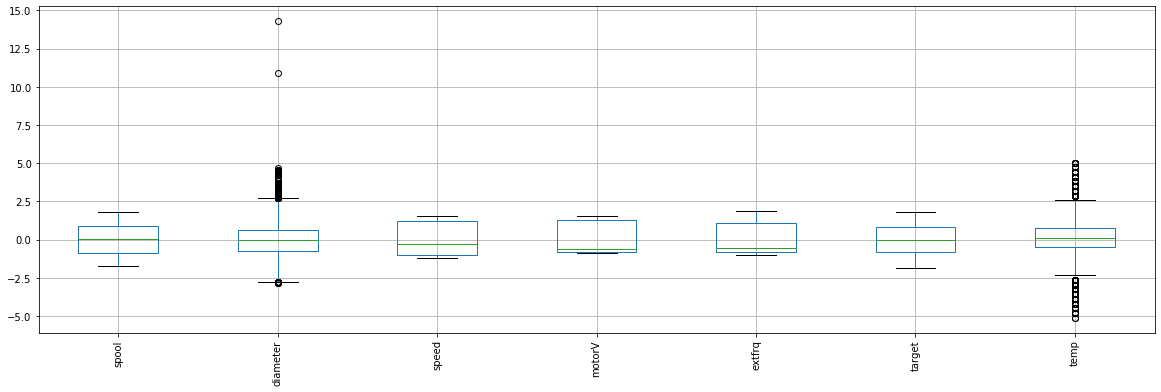

In [9]:
cols = train_all.columns
# Z-Score
for col in cols:
    train_all[col] = (train_all[col] - train_all[col].mean())/train_all[col].std(ddof=0)

train_all.boxplot(figsize=(20,6), rot=90)

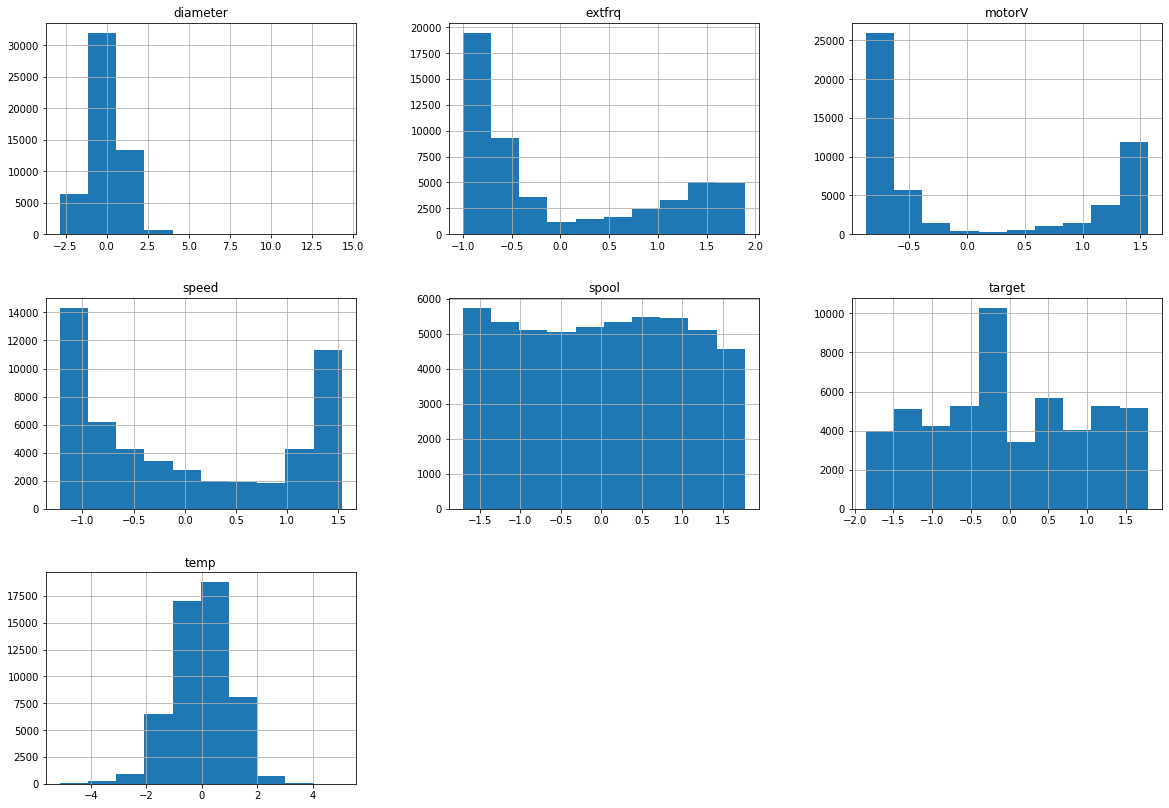

In [10]:
hist = train_all.hist(figsize=(20,14))

[Text(0.5, 0, 'spool'),
 Text(1.5, 0, 'diameter'),
 Text(2.5, 0, 'speed'),
 Text(3.5, 0, 'motorV'),
 Text(4.5, 0, 'extfrq'),
 Text(5.5, 0, 'target'),
 Text(6.5, 0, 'temp')]

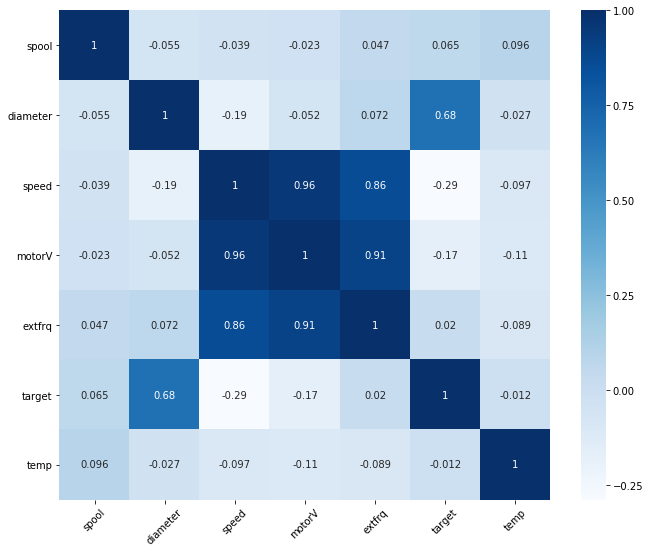

In [11]:
# Correlation Plot
f, ax = plt.subplots(figsize=(11, 9))
cor = train_all.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

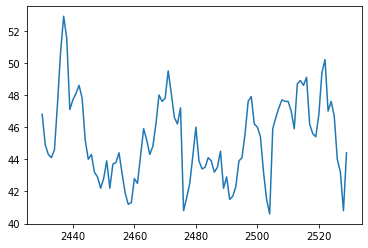

In [12]:
x = 0
y = df['diameter'][-100:]
plt.plot(y)